In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:


!pip install --quiet protobuf==3.20.3 thop==0.1.1.post2209072238
!pip install --quiet transformers==4.41.2 torch torchvision torchaudio
!pip install --quiet accelerate --upgrade

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # stops cuDNN/cuFFT re-register warnings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # helps debug if CUDA crash happens

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import ViTModel
from transformers.models.vit.modeling_vit import ViTEncoder
import numpy as np
import cv2
import os


# Paths and parameters
folder_path = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
subfolders = ['Monkeypox_augmented', 'Others_augmented']
image_size = (224, 224)
batch_size = 16
epochs = 30
learning_rate = 0.0001
gamma = 0.5  # Weight for combining deep and broad features

# image transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data = []
labels = []
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            data.append(img)
            labels.append(label_map[subfolder])

data = np.array(data).astype("float32")
labels = np.array(labels)

data = torch.tensor(data).permute(0, 3, 1, 2) / 255.0
labels = torch.tensor(labels)

dataset = TensorDataset(data, labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Broad Attention Mechanism
class BroadAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(BroadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, queries, keys, values):
        queries = torch.cat(queries, dim=1)
        keys = torch.cat(keys, dim=1)
        values = torch.cat(values, dim=1)
        attention_output, _ = self.attention(queries, keys, values)
        pooled_output = self.pool(attention_output.permute(0, 2, 1)).squeeze(-1)
        return pooled_output

# MVIT-Integrated B2VIT Model
class B2MVITNet(nn.Module):
    def __init__(self, vit_model_name, num_classes, gamma=0.5):
        super(B2MVITNet, self).__init__()
        self.vit = ViTModel.from_pretrained(vit_model_name, output_attentions=True)
        self.hidden_size = self.vit.config.hidden_size
        self.num_layers = len(self.vit.encoder.layer)
        self.gamma = gamma

        # Multiscale Fusion
        self.mvit_encoder = ViTEncoder(self.vit.config)
        self.mvit_attention = nn.MultiheadAttention(embed_dim=self.hidden_size, num_heads=8)
        
        # Broad Attention Mechanism
        self.broad_attention = BroadAttention(hidden_size=self.hidden_size, num_layers=self.num_layers)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        deep_features = hidden_states[-1][:, 0, :]
        queries = [layer[:, 0, :].unsqueeze(1) for layer in hidden_states]
        broad_features = self.broad_attention(queries, queries, queries)

        # MVIT Feature Extraction
        mvit_outputs = self.mvit_encoder(hidden_states[-1])
        mvit_features = mvit_outputs.last_hidden_state[:, 0, :]

        # Combine Features
        combined_features = torch.cat((deep_features, self.gamma * broad_features + mvit_features), dim=1)
        logits = self.classifier(combined_features)
        return logits




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dep

In [3]:
# Training function without plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_accuracy = accuracy_score(train_targets, train_preds)

        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = accuracy_score(val_targets, val_preds)

        # Collect losses and accuracies for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print out the progress of training
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")



Fold 1


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/30: Train Loss: 0.4685, Train Accuracy: 0.8316, Val Loss: 0.3291, Val Accuracy: 0.8795
Epoch 2/30: Train Loss: 0.1145, Train Accuracy: 0.9628, Val Loss: 0.2728, Val Accuracy: 0.9249
Epoch 3/30: Train Loss: 0.1267, Train Accuracy: 0.9600, Val Loss: 0.1537, Val Accuracy: 0.9390
Epoch 4/30: Train Loss: 0.0414, Train Accuracy: 0.9855, Val Loss: 0.2276, Val Accuracy: 0.9108
Epoch 5/30: Train Loss: 0.0519, Train Accuracy: 0.9847, Val Loss: 0.2023, Val Accuracy: 0.9296
Epoch 6/30: Train Loss: 0.0503, Train Accuracy: 0.9859, Val Loss: 0.0674, Val Accuracy: 0.9890
Epoch 7/30: Train Loss: 0.0366, Train Accuracy: 0.9914, Val Loss: 0.1433, Val Accuracy: 0.9296
Epoch 8/30: Train Loss: 0.0668, Train Accuracy: 0.9769, Val Loss: 0.0401, Val Accuracy: 0.9859
Epoch 9/30: Train Loss: 0.0422, Train Accuracy: 0.9863, Val Loss: 0.0849, Val Accuracy: 0.9844
Epoch 10/30: Train Loss: 0.0006, Train Accuracy: 1.0000, Val Loss: 0.0984, Val Accuracy: 0.9890
Epoch 11/30: Train Loss: 0.0001, Train Accuracy: 

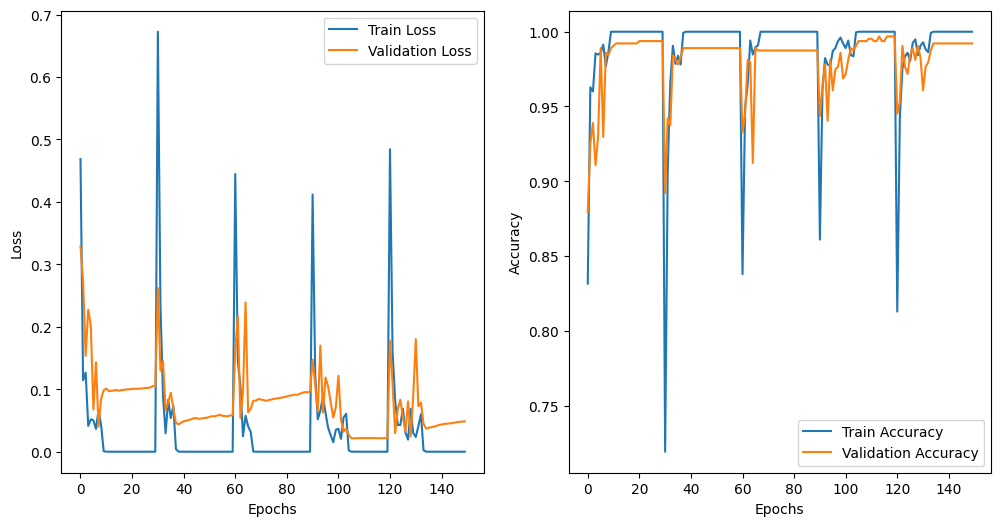

In [4]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from transformers import ViTModel
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import cv2
from transformers.models.vit.modeling_vit import ViTEncoder

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_preds, test_targets = [], []
    tn, fp, fn, tp = 0, 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

            # Calculate confusion matrix components for specificity
            for true, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                if true == 0 and pred == 0:
                    tn += 1
                elif true == 0 and pred == 1:
                    fp += 1
                elif true == 1 and pred == 0:
                    fn += 1
                elif true == 1 and pred == 1:
                    tp += 1


    precision = precision_score(test_targets, test_preds, average='weighted')
    recall = recall_score(test_targets, test_preds, average='weighted')
    f1 = f1_score(test_targets, test_preds, average='weighted')
    accuracy = accuracy_score(test_targets, test_preds)

    specificity = tn / (tn + fp)

    report = classification_report(test_targets, test_preds, target_names=subfolders)
    print(report)

    return accuracy, precision, recall, f1, specificity

# 5-Fold Cross-Validation loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
fold_specificity = []

# Lists to store the overall metrics across all folds for plotting
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold + 1}")

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = B2MVITNet("google/vit-base-patch16-224-in21k", num_classes=2, gamma=gamma).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)
    all_train_accuracies.extend(train_accuracies)
    all_val_accuracies.extend(val_accuracies)

    accuracy, precision, recall, f1, specificity = evaluate_model(model, val_loader)
    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Specificity: {specificity:.4f}")
    fold_results.append((accuracy, precision, recall, f1))
    fold_specificity.append(specificity)

average_results = np.mean(fold_results, axis=0)
average_specificity = np.mean(fold_specificity)

print("\n5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {average_results[0]:.4f}")
print(f"Average Precision: {average_results[1]:.4f}")
print(f"Average Recall: {average_results[2]:.4f}")
print(f"Average F1 Score: {average_results[3]:.4f}")
print(f"Average Specificity: {average_specificity:.4f}")

plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs * 5), all_train_losses, label="Train Loss")
plt.plot(range(epochs * 5), all_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs * 5), all_train_accuracies, label="Train Accuracy")
plt.plot(range(epochs * 5), all_val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


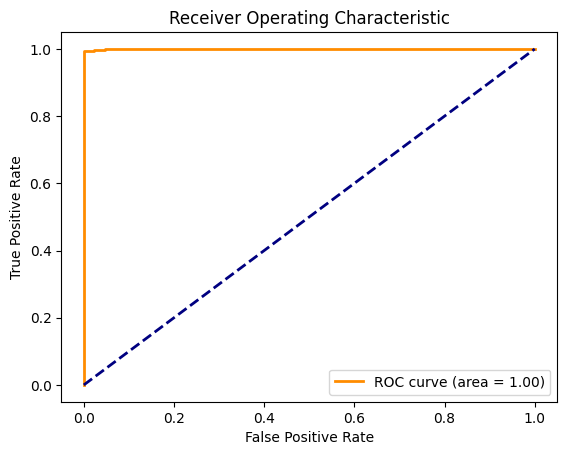

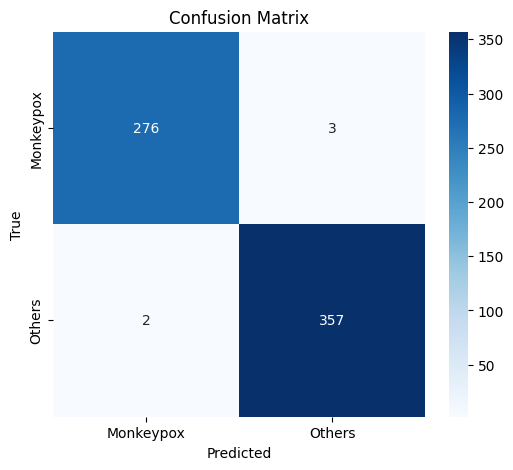

In [5]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])  # Assuming binary classification (class 1 is positive)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Monkeypox', 'Others'], yticklabels=['Monkeypox', 'Others'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


plot_roc_curve(model, val_loader) 
plot_confusion_matrix(model, val_loader)  


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


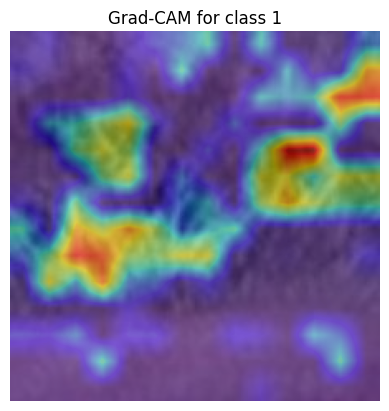

In [6]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification

def generate_vit_gradcam(model, image, target_class, device):
    model.eval()

    #Hook to capture activations and gradients
    activations, gradients = None, None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output  # Capture the output activations

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]  # Capture the gradients

    #Register hooks on the last encoder block's output
    last_layer = model.vit.encoder.layer[-1].output
    forward_hook_handle = last_layer.register_forward_hook(forward_hook)
    backward_hook_handle = last_layer.register_backward_hook(backward_hook)

    #Forward pass
    image = image.to(device)
    logits = model(image).logits
    loss = logits[0, target_class]
    loss.backward()

    #Computing Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=0) 
    activations = activations[0]  

    #Removing the class token (first token)
    activations = activations[1:]  # Removing the class token (index 0)
    
    #Compute the Grad-CAM map
    gradcam_map = torch.einsum("ij,kj->i", [activations, pooled_gradients])  # Matrix multiplication

    #Reshape the Grad-CAM map to the grid size (only patch tokens)
    num_patches = gradcam_map.shape[0]
    grid_size = int(math.sqrt(num_patches))
    gradcam_map = gradcam_map.view(grid_size, grid_size).cpu().detach().numpy()

    #Normalizing Grad-CAM
    gradcam_map = np.maximum(gradcam_map, 0)  # Apply ReLU to remove negative values
    gradcam_map -= gradcam_map.min()  # Normalize to [0, 1]
    gradcam_map /= gradcam_map.max()
    gradcam_map = cv2.resize(gradcam_map, (224, 224))  # Resize to original image size

    # De-normalizing the input image
    original_image = image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)
    original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    original_image = np.clip(original_image, 0, 1)

    plt.imshow(original_image)
    plt.imshow(gradcam_map, alpha=0.5, cmap='jet')
    plt.title(f"Grad-CAM for class {target_class}")
    plt.axis("off")
    plt.show()

    # Remove hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

# Load the model and preprocess the image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k").to(device)

image_path = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images/Monkeypox_augmented/M01_02_01.jpg"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Prepare the input image
sample_image = Image.open(image_path).convert("RGB")
sample_image_tensor = transform(sample_image).unsqueeze(0)

#Generate Grad-CAM
generate_vit_gradcam(model, sample_image_tensor, target_class=1, device=device)


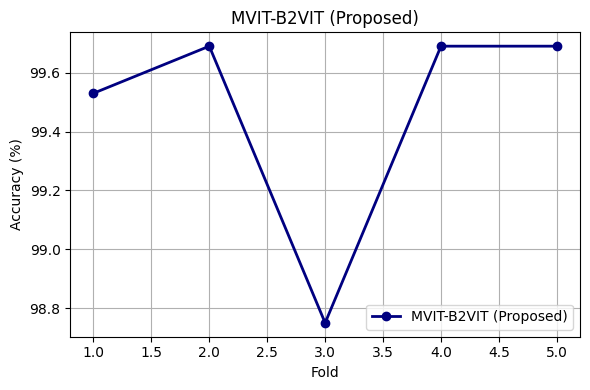

In [7]:
import matplotlib.pyplot as plt

accuracies = [99.53, 99.69,98.75, 99.69, 99.69]
folds = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 4))
plt.plot(folds, accuracies, marker='o', color='navy', linewidth=2)
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('MVIT-B2VIT (Proposed)')
plt.grid(True)
plt.legend(['MVIT-B2VIT (Proposed)'], loc='lower right')
plt.tight_layout()
plt.show()


In [8]:

!pip install thop

from thop import profile
import time
import torch

model.eval()
model.to("cpu")

# Dummy input (1 image of size 3x224x224)
dummy_input = torch.randn(1, 3, 224, 224)

flops, params = profile(model, inputs=(dummy_input,), verbose=False)

print("=====================================")
print("🧮 MODEL COMPUTATIONAL METRICS")
print("=====================================")
print(f"Total Parameters : {params / 1e6:.3f} Million")
print(f"Total FLOPs       : {flops / 1e9:.3f} GFLOPs")

#Inference Time & Throughput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dummy_input = dummy_input.to(device)

#Warm-up phase (GPU optimization)
for _ in range(5):
    _ = model(dummy_input)

#Timed inference (average over 50 runs)
torch.cuda.synchronize() if device.type == "cuda" else None
start_time = time.time()
for _ in range(50):
    _ = model(dummy_input)
torch.cuda.synchronize() if device.type == "cuda" else None
end_time = time.time()

avg_inference_time = (end_time - start_time) / 50  # seconds per image
throughput = 1 / avg_inference_time  # images per second

print(f"\n⚡ Average Inference Time per Image : {avg_inference_time*1000:.3f} ms")
print(f"📈 Throughput                      : {throughput:.2f} images/sec")
print("=====================================")


🧮 MODEL COMPUTATIONAL METRICS
Total Parameters : 85.648 Million
Total FLOPs       : 16.863 GFLOPs

⚡ Average Inference Time per Image : 20.287 ms
📈 Throughput                      : 49.29 images/sec
